In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
train_dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='./data/',
                                          train=False, 
                                          transform=torchvision.transforms.ToTensor(),
                                          download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



5


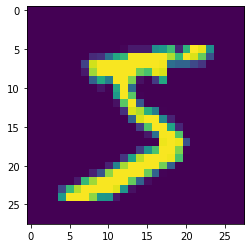

In [3]:
image, label = train_dataset[0]

plt.imshow(image.squeeze())
print(label)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [5]:
class PyNet(torch.nn.Module):
  def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.cnn_model = torch.nn.Sequential( 
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5, 5)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2)),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2)),
            torch.nn.ReLU()            
        )
        self.fc_model = torch.nn.Sequential(
            torch.nn.Linear(in_features=4*4*64, out_features=64),
            torch.nn.ReLU()
        )
        self.classifier = torch.nn.Linear(64, 10)

  def forward(self, x):
        x = self.cnn_model(x)
        x = self.flatten(x)
        x =  self.fc_model(x)
        out = self.classifier(x)
        return out

modelpy = PyNet().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelpy.parameters())

modelpy

PyNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn_model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (fc_model): Sequential(
    (0): Linear(in_features=1024, out_features=64, bias=True)
    (1): ReLU()
  )
  (classifier): Linear(in_features=64, out_features=10, bias=True)
)

In [6]:
def train(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    size = len(dataloader.dataset)
    dur = []
    train_accuracy = []
    test_accuracy = []
    training_start_time = time.time()
    for e in range(epoch):
      t0 = time.time()
      loss, test_loss, correct = 0, 0, 0
      for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        test_loss = loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
      stop_time=time.time()
      duration =stop_time-t0
      
      dur.append(duration)

      print(f"Epoch: {e+1}, loss: {test_loss:>5f}, accuracy: {(correct / size):>5f}, time: {duration:>5f}")
              
train(train_dataloader, modelpy, loss_fn, optimizer, epoch=10)

Epoch: 1, loss: 0.098083, accuracy: 0.954017, time: 55.842280
Epoch: 2, loss: 0.028192, accuracy: 0.985733, time: 55.415607
Epoch: 3, loss: 0.005388, accuracy: 0.990350, time: 55.328667
Epoch: 4, loss: 0.001226, accuracy: 0.992967, time: 55.563390
Epoch: 5, loss: 0.000345, accuracy: 0.994733, time: 55.256471
Epoch: 6, loss: 0.000091, accuracy: 0.995117, time: 54.922965
Epoch: 7, loss: 0.001134, accuracy: 0.995983, time: 55.269575
Epoch: 8, loss: 0.000042, accuracy: 0.996917, time: 55.066914
Epoch: 9, loss: 0.000049, accuracy: 0.997133, time: 56.566975
Epoch: 10, loss: 0.000021, accuracy: 0.997167, time: 55.172350


In [7]:
modelpy.eval()
size = len(test_dataloader.dataset)
test_loss, correct = 0, 0

with torch.no_grad():
  for X, y in test_dataloader:
    pred = modelpy(X)
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()

print(f"Test Result- accuracy: {(correct / size):>5f}")

Test Result- accuracy: 0.990700
